# M1 Model Checkpoint Analysis

Here I ensure the reproducability of results from training experiments produced 
using the scripts in `src/execute_m1.py`, `src/train_m1.py`. 
 - Load model.
 - Compute performance metrics. 
 - Visualize 10-frame autoencoding results. 

The first run of model checkpoints are in `training/2022_10_25/`

In [2]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

In [3]:
## GPU Setup
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## 0: Getting the Dataset

_Copy-pasted from `execute_m1.py`_

In [111]:
## Acquiring the dataset!
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp

# Meta/constants -- TODO: These should be commandline arguments. 
DATA_FOLDER = "../datasets/downloads"
num_frames = 4
output_size = (120, 180)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size = 20
num_prefetch = 4

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

# Mp4 list: 
mp4_list = os.listdir(DATA_FOLDER)
mp4_list = mp4_list[:4]

print("\n\n\n")
print("\t=========================")
print("\t=== DATASET META INFO ===")
print("\t=========================")
print("num_frames: ", num_frames)
print("batch_size: ", batch_size)
print("output_size: ", output_size)
print("Patch h/w/d: ", patch_height, patch_width, patch_duration)
print("k, mu for space, time: ", (k_space, mu_space), (k_time, mu_time))
print("mp4_list[:10] -- ", mp4_list[:10])


## Creating the generator
print("\n\n\n")
print("\t========================")
print("\t=== DATASET CREATION ===")
print("\t========================")
def generate_video_tensors():
	""" This is a generator for raw video tensors of shape 
	[num_frames, height, width, channels]. 

	It uses global variables defined above under "meta/constants". These 
	will be commandline arguments in the future. 
	"""
	_mp4_list = mp4_list
	_DATA_FOLDER = DATA_FOLDER
	_output_size = output_size
	_num_frames = num_frames
	while True: 
		for fname in _mp4_list:
			try:
				retval = vl.get_single_video_tensor(os.path.join(_DATA_FOLDER, fname), _num_frames, output_size=_output_size)
			except:
				continue
			if type(retval) == np.ndarray and retval.shape[0] == _num_frames:
				yield np.expand_dims(retval, axis=0)

videoset = tf.data.Dataset.from_generator(generate_video_tensors, output_signature=tf.TensorSpec(shape=[1, num_frames, *output_size, 3], dtype=tf.float32))
print(videoset)

def show_nn_sq(video_tensor, n=3, outname="breh.png"):
	n2 = n*n
	fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True)

	_nframes = video_tensor.shape[0]
	frame_inc = _nframes//(n2)

	for i in range(n):
		for j in range(n):
			full_idx = i*n + j

			axs[i,j].imshow(video_tensor[frame_inc*full_idx,:,:,:])
			axs[i,j].set_title(f"Frame {frame_inc*full_idx}")

	fig.suptitle(f"Video Survey over {_nframes} Frames")
	plt.savefig(outname)
	plt.show()

"""
out_test = "debug/test_from_videoset.png"
print(f"Showing off an element of the videodataset(generator) in `{out_test}`")	
for element in videoset:
	show_nn_sq(tf.squeeze(element), outname=out_test)
	break
"""

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(videoset, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=1)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=1)
FlatCodedPatchedSet = FlatCodedPatchedSet.map(lambda x: tf.squeeze(x))
FlatCodedPatchedSet = FlatCodedPatchedSet.batch(batch_size)
FlatCodedPatchedSet = FlatCodedPatchedSet.prefetch(num_prefetch)

cnt = 0
for el in FlatCodedPatchedSet: 
	print(" ** Shape of FlatCodedPatchedSet element: ", el.shape)
	cnt += 1
	if cnt == 2:
		break

print("Done getting datasets setup!")

2022-10-27 20:38:07.248935: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.
Traceback (most recent call last):

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.


2022-10-27 20:38:07.328678: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) whe





	=== DATASET META INFO ===
num_frames:  4
batch_size:  20
output_size:  (120, 180)
Patch h/w/d:  16 16 3
k, mu for space, time:  (15, 20) (64, 200)
mp4_list[:10] --  ['H1iWETEMl7c.mp4', 'PmKbAgKa_V8.mp4', 'zymMiwUtbqE.mp4', 'jpeB76IUI9c.mp4']




	=== DATASET CREATION ===
<FlatMapDataset element_spec=TensorSpec(shape=(1, 4, 120, 180, 3), dtype=tf.float32, name=None)>
Making patches from Videoset...
Making the flat patch set...
Adding codes to the PatchSet...


2022-10-27 20:38:07.489243: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.
Traceback (most recent call last):

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.


2022-10-27 20:38:07.571982: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) whe

Flattening the coded + patched dataset...


2022-10-27 20:38:07.732149: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.
Traceback (most recent call last):

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/aman/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) where an element of shape (1, 4, 120, 180, 3) was expected.


2022-10-27 20:38:07.800896: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (1, 3, 120, 180, 3) whe

 ** Shape of FlatCodedPatchedSet element:  (20, 77, 2495)
 ** Shape of FlatCodedPatchedSet element:  (20, 77, 2495)
Done getting datasets setup!


## 1: Initializing Perceiver AE Model

_Random weights, checkpoint weights will be inserted next_

In [112]:
## Setting up the model
print("\t========================")
print("\t=== SETTING UP MODEL ===")
print("\t========================")

import m1
## Setting up the component modules of the top-level PAE model.
# Encoder 
n_encoder_blocks = 3
p_droptoken = 0.5
re_droptoken = True
encoder_tfres = False
enc_nheads = 15
enc_keydim = 15
enc_mhadropout = 0.0
test_encoder = m1.PAE_Encoder(n_encoder_blocks, p_droptoken=p_droptoken, re_droptoken=re_droptoken, tfblock_residual=encoder_tfres, n_heads=enc_nheads, key_dim=enc_keydim, mha_dropout=enc_mhadropout)

# Latent evolver 
n_latentev_blocks = 3
latent_distinct_blocks = False
latent_residual = False
latent_nheads = 15
latent_keydim = 15
latent_mhadropout=0.0
test_latent_ev = m1.PAE_Latent_Evolver(n_latentev_blocks, distinct_blocks=latent_distinct_blocks, tfblock_residual=latent_residual, n_heads=latent_nheads, key_dim = latent_keydim, mha_dropout=latent_mhadropout)


# decoder
output_patch_dim = 2304
n_decoder_blocks = 3
expansion_block_num = 2
decoder_tfres = False
dec_nheads = 15
dec_keydim = 15
dec_mhadropout = 0.0
test_decoder = m1.PAE_Decoder(output_patch_dim, n_decoder_blocks, expansion_block_num, tfblock_residual=decoder_tfres, n_heads=dec_nheads, key_dim=dec_keydim, mha_dropout=dec_mhadropout)

# loss function
mse = tf.keras.losses.MeanSquaredError()

## Instantiating the PAE model!
perceiver_ae = m1.PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, code_dim=191, latent_dims=(700,100))

perceiver_ae.reset_latent()


print("Done setting up perceiver_ae model!")

	=== SETTING UP MODEL ===
Done setting up perceiver_ae model!


## 2: Obtaining Checkpoint Information

Question: Can we insert checkpoint weights even if we initialize with a different 
number of encoder blocks? 

 - No error upon loading in weights!
 - No error when loading weights into model with different # latent blocks!
 - Cumulative loss over 3 "exposures" = 0.19 -- in line with test performance!

In [187]:
# checkpoint_path = "../training/2022_10_25/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_dir = "../training/debug/2022-10-27_01:12:56/checkpoints"
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest = '../training/debug/2022-10-27_01:12:56/checkpoints/cp-1000.ckpt'
latest

'../training/debug/2022-10-27_01:12:56/checkpoints/cp-1000.ckpt'

In [188]:
perceiver_ae.load_weights(latest)
print("N, C: ", perceiver_ae.N, perceiver_ae.C)

N, C:  700 100


In [115]:
## Calling the model on some data
ele = None
for element in FlatCodedPatchedSet:
	ele = element
	break

ele.shape

TensorShape([20, 77, 2495])

In [189]:
perceiver_ae.reset_latent(B=20)
# loss1 = perceiver_ae(ele, reset_latent=True)
print("Latent shape: ", perceiver_ae.latent.shape)

codes = ele[:,:,-perceiver_ae.code_dim:]

print("Spacetime codes shape: ", codes.shape)

prediction = perceiver_ae.decoder([codes, perceiver_ae.latent])
prediction.shape

Latent shape:  (20, 700, 100)
Spacetime codes shape:  (20, 77, 191)


TensorShape([20, 77, 2304])

In [190]:
loss1 = perceiver_ae(ele, reset_latent=True)
loss2 = perceiver_ae(ele)

In [191]:
loss3 = perceiver_ae(ele)

In [192]:
print("Loss 1: ", loss1)
print("Loss 2: ", loss2)
print("Loss 3: ", loss3)
print("\n\tSUM: ", loss1+loss2+loss3)

Loss 1:  tf.Tensor(0.09851047, shape=(), dtype=float32)
Loss 2:  tf.Tensor(0.04879892, shape=(), dtype=float32)
Loss 3:  tf.Tensor(0.048775766, shape=(), dtype=float32)

	SUM:  tf.Tensor(0.19608516, shape=(), dtype=float32)


In [193]:
perceiver_ae.encoder.p_droptoken

0.5

## 2: Visualizing the Reconstructions

In [194]:
patch_height = 16
patch_width = 16
patch_duration = 3
num_frames = 3
output_size = (120,180)


def get_source_video(flatpatched_coded):

	n_time_patches = num_frames // patch_duration
	n_height_patches = output_size[0] // patch_height 
	n_width_patches = output_size[1] // patch_width 

	x = flatpatched_coded

	x_patch = vp.unflatten_patched(x, n_time_patches, n_height_patches, n_width_patches)
	print("x_patch shape: ", x_patch.shape)
	print("p_dur, p_height, p_width: ", patch_duration, patch_height, patch_width)
	x_3dpatch = vp.make_3D_patches(x_patch, patch_duration, patch_height, patch_width)
	x_video = vp.get_vidtensor_from_8D(x_3dpatch)

	return x_video

In [195]:
ele[:,:,:-191].shape

TensorShape([20, 77, 2304])

In [196]:
source_video = get_source_video(ele[:,:,:-191])
source_video.shape

x_patch shape:  (20, 1, 7, 11, 2304)
p_dur, p_height, p_width:  3 16 16


TensorShape([20, 3, 112, 176, 3])

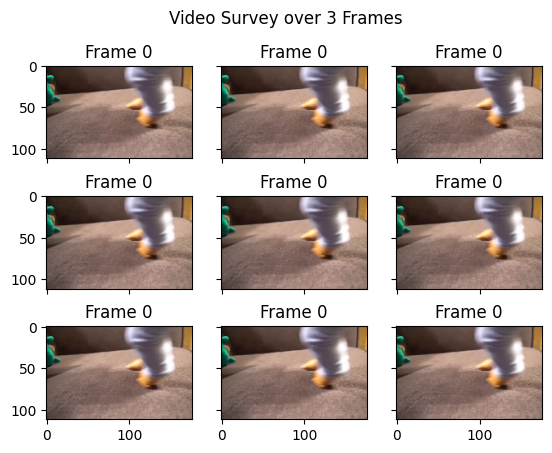

In [197]:
show_nn_sq(source_video[1,:,:,:,:], outname="breh.png")

In [198]:
## Reconstruction
loss1 = perceiver_ae(ele, return_prediction=False, reset_latent=True)
loss2 = perceiver_ae(ele, return_prediction=False)
loss3, reconst = perceiver_ae(ele, return_prediction=True)

print(loss1.numpy(),loss2.numpy(),loss3.numpy())


0.09851047 0.048804563 0.048775274


In [199]:
reconst_vid = get_source_video(reconst)
reconst_vid.shape

x_patch shape:  (20, 1, 7, 11, 2304)
p_dur, p_height, p_width:  3 16 16


TensorShape([20, 3, 112, 176, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


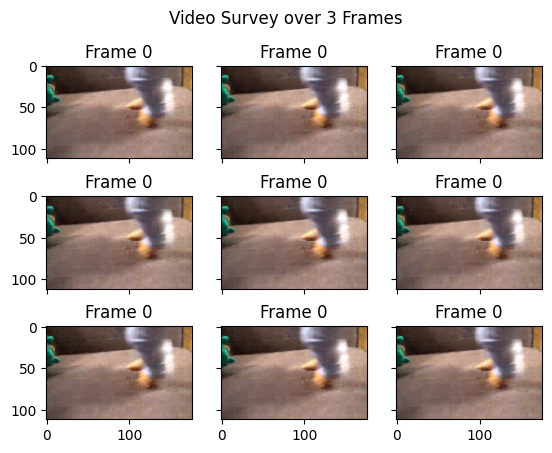

: 

In [200]:
show_nn_sq(reconst_vid[1,:,:,:,:], outname="breh.png")

In [80]:
tf.reduce_min(reconst_vid)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.024054598>

In [81]:
tf.reduce_max(reconst_vid)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0133615>